In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

In [3]:
n_steps = 50
batch_size = 10000
series = generate_time_series(batch_size, n_steps + 1)
x_train, y_train = series[:7000, :n_steps], series[:7000, -1]
x_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
x_test, y_test = series[9000:, :n_steps], series[9000:, -1]

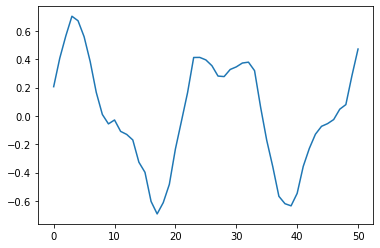

In [4]:
plt.plot(series[0])
plt.show()

In [5]:
"""
간단한 RNN 구조
keras의 SimpleRNN 에서는 기본적으로 tanh를 활성화 함수로 사용
RNN의 경우 입력 데이터의 길이에 상관 없이 time step 처리할 수 있기 때문에 input_shape=[None, 1]
return_sequence=True : time step마다 출력 return
하지 않으면 마지막 time step의 결과만 출력
다음 layer를 RNN 구조 이용하려면 return_sequence=True 해야함
마무리로 Dense 사용한 것 : SimpleRNN은 tanh를 활성화 함수로 이용하기에 결과는 -1, 1 사이
다른 활성화 함수 사용하거나 더 빠른 계산 위해 Dense 사용
"""

model = tf.keras.models.Sequential([
              tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
              tf.keras.layers.SimpleRNN(20),
              tf.keras.layers.Dense(1)
])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 20)          440       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [7]:
"""
LSTM (장단기 메모리 셀) 기본 구조
데이터의 장기간 의존성을 위해 사용
TimeDistributed : 입력 층의 모든 time step에 (...)의 내용을 적용 => 각 time step을 별개의 샘플로 다룰 때 효과적
"""
model2 = tf.keras.models.Sequential([
              tf.keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
              tf.keras.layers.LSTM(20, return_sequences=True),
              tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10))
])

In [8]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 20)          1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          210       
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


In [9]:
"""
1D Conv 이용해 sequence 처리하기
1D Conv 층을 이용해 커널로 슬라이딩하며 특성을 골라냄 (1D 특성 맵)
strides, padding을 이용해 적절한 타깃을 만들어야 한다.
모델의 중요하지 않은 정보를 버리고 중요 정보만 LSTM, GRU 층으로 넘기려면 
합성곱(Conv)으로 sequence 길이 줄여야 함 (ex) kernel_size=4, strides=2, padding="valid" => 반으로 다운 샘플링
"""
model3 = tf.keras.models.Sequential([
                tf.keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[None, 1]),
                tf.keras.layers.GRU(20, return_sequences=True),
                tf.keras.layers.GRU(20, return_sequences=True),
                tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10))
])

In [10]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 20)          100       
_________________________________________________________________
gru (GRU)                    (None, None, 20)          2520      
_________________________________________________________________
gru_1 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 10)          210       
Total params: 5,350
Trainable params: 5,350
Non-trainable params: 0
_________________________________________________________________
